<div class="usecase-section-header">Greening Laneways to reduce overland water flow events</div>

<div class="usecase-authors"><b>Authored by: </b>Alison Collins</div>
<div class="usecase-duration"><b>Duration: </b>60 mins</div>
<div class="usecase-level"><b>Level: </b>beginner</div>
<div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>


<div class="usecase-section-header">Scenario</div>

1. As a city planner, I want to identify the laneways that could most benefit from planting to reduce overland water runoff as part of the Greening Your Laneway program.

2. As a building manager or residence owner, I want to visualise the potential of laneway greening in reducing water damage to my property from overflow events.

<div class="usecase-section-header">Learning Objectives</div>

At the end of this use case you will be able to:
* Work with spatial databases using Geopandas
* Visualise spatial data on an interactive map

<div class="usecase-section-header">Greening Laneways to Reduce Runoff</div>

##### **What is the Green Your Laneway Program?**

The Green Your Laneway program was established in 2017 with aa pilot project of four Laneways: Katherine Place, Meyers Place, Guildford Lane and Coromandel Place <a href="#fn-1">[1]</a>. These laneways were greened using a mixture of potted plants on windowsills and nature strips as well as creeper vines. The benefits of greening laneways include <a href="#fn-1">[2]</a>:

- oxygen production for fresh air to breathe
- storage of carbon dioxide, helping reduce green house gases
- trees absorb water, helping reduce flooding events
- evapotranspiration from leaves produces a cooling effect, reducing heat waves
- provide habitats for wildlife
- trees reduce cortisol in our brains, improving mental health and wellbeing


##### **How do plants reduce surface water overflow?**

Plants and soil will absorb some of the excess water during rain events <a href="#fn-1">[3]</a>. One problem that occurs within Melboune city is the runoff of water over roads. Due to non-permeable surfaces, water runs across the top of the land prior to enterinng a stormwater drain or collecting in lower lying areas, causing "rivers" of water on roads and laneways in the CBD <a href="#fn-1">[4]</a>. For this reason, consideration of the locations where water flows over land should be investigated in regards to selecting laneways for future Green Your Laneway project locations.

<div class="usecase-section-header">Relevant datasets</div>

[Laneways with Greening Potential](https://data.melbourne.vic.gov.au/explore/dataset/laneways-with-greening-potential/export/)
- The City of Melbourne collected data analysing the best potential type of plantings in each of the city laneways; farm plantings, park species, vertically growing species and forest type species. In each laneway, the type of planting was given a categorical value of potential for types of planting: Highest, Good, Some or Lowest.

[Water flow routes over land (Urban Forest)](https://data.melbourne.vic.gov.au/explore/dataset/water-flow-routes-over-land-urban-forest/export/)
- Data was collected in 2008 using an ESRI Spatial Analyst stream order tool to determine loctions of water flow over surface. Each location of water flow has the stream order indicated in the grid-code field. Higher values in this field mean that water is fed into this area with water from other laneways and roads. 

<div class="usecase-section-header">Exploratory data analysis steps</div>

1. Import modules
2. Access and read in data sets, undertake preprocessing
3. Map overlap locations of water runoff and laneways
4. Return overlap location of surface water and laneways



##### **Import Modules**

In [99]:
# Import modules
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import mapclassify


##### **Read in data and preprocessing**

In [2]:
# Function to get data from website using API
def get_data_single(base, SPECIFIC_PATH, apikey, offset=0):    
    # Set the filters, limit retrieves 20 rows at a time, offset says where to start data collection
    filters = f'records?limit={100}&offset={offset}&timezone=UTC'
    # Make the url from base, data url and filters variables stored ouside loop
    url = f'{base}{SPECIFIC_PATH}/{filters}&apikey={apikey}'
    # print(url) - can be used locally to check if code is working if 404 error given
    # Use the requests function to get the data
    result = requests.get(url)
    # Check that the request works, error code 200 = successful
    if result.status_code == 200:
        # Save results as a json file
        result_json = result.json()
        # Store a variable of max_results with total of dataset
        max_results = result_json['total_count']
        # Save the results key data to a list variable
        records = result_json['results']
    else:
        # If data is not collected correctly return the error
        print("ERROR GETTING DATA: ", result.status_code)
        max_results = 0
        records = []
    # At end of function, return the json results in records, max_results count and offset
    return [records, max_results, offset]


def fetch_all_data(SPECIFIC_PATH):
    # Collect data from API
    # Set offset increment
    # (needs to match offset in get data function)
    OFFSET_INCREMENT = 100
    # Base url (this should be the same for all datasets)
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    # Set your API key
    # Set path to your API key
    # (needs to be a destination on your local device where API is kept)
    path = 'C:/Users/alito/Documents/SIT764/MOP-Code/env.txt'
    apikey_local = open(path, 'r')
    apikey = apikey_local.read()   
    # Call the get data function, passing in variables above, save to result
    result = get_data_single(base_url, SPECIFIC_PATH, apikey)
    # Save the records data returned in the get_data function to records list variable
    records = result[0]
    # Save the dataset size data returned in the get_data function to max_results variable
    max_results = result[1] 
    # Increase the offset returned in the get_data function (result[2]) by the offset increment
    offset = result[2] + OFFSET_INCREMENT
    # Check the length of the data returned and compare it against the max_results variable
    # If the length o fthe data is less than the max_results, run the while loop
    while len(records) != max_results:
        # Call the get data function again, passing in url, specific path and new offset value
        data = get_data_single(base_url, SPECIFIC_PATH, apikey, offset)
        # Add the data collected to the existing records list
        records += data[0]
        # Increase the offset by the offset increment
        offset += OFFSET_INCREMENT
    # Convert the records list of dictionaries into a pandas dataframe 
    df = pd.DataFrame(records)
    # Print the dataframe
    return df

In [93]:
# Read in Laneways with Greening Potential Dataset and convert to Geopandas
# Set specific url 
SPECIFIC_PATH = 'laneways-with-greening-potential'
# Collect data
lane_df = fetch_all_data(SPECIFIC_PATH)
# Extract the geo_point_2d column and put into a new dataframe as two columns, lat and lon
parsed = pd.DataFrame.from_records(lane_df['geo_point_2d'])
# Add extracted columns lat and lon to lane dataframe
lane_df[['lon','lat']]= parsed[['lon','lat']]
# Convert lane dataframe to geodataframe, joiing lon and lat columsn to make a geometry column
lane_gdf = gpd.GeoDataFrame(
    lane_df, geometry=gpd.points_from_xy(lane_df.lon, lane_df.lat), crs="EPSG:4326")
# Print first two rows of lane_gdf dataframe
lane_gdf.head(2)

,geo_point_2d,geo_shape,segid_1,mapbase_mc,insol_scor,verticalsu,segid,driveways,parklane,objectid,...,vert_rank,fores_rank,forest,park_rank,binsperct,mapbase_1,wsud,lon,lat,geometry
0,"{'lon': 144.9623447558369, 'lat': -37.81980050...","{'type': 'Feature', 'geometry': {'coordinates'...",10714,10714.0,6.492595,0.0,10714,1,53.830526,1,...,Lowest potential,Lowest potential,0.000000,Highest potential,0.0,Banana Alley,Probably Unsuitable,144.962345,-37.819801,POINT (144.96234 -37.81980)
1,"{'lon': 144.97170834375964, 'lat': -37.8109763...","{'type': 'Feature', 'geometry': {'coordinates'...",20229,20229.0,2.215613,0.0,20229,2,0.000000,5,...,Lowest potential,Good potential,49.153357,Lowest potential,60.0,Harwood Place,Consider,144.971708,-37.810976,POINT (144.97171 -37.81098)


In [103]:
# Read in Water flow routes over land (Urban Forest) Dataset and convert to Geopandas
# Set specific url 
SPECIFIC_PATH = 'water-flow-routes-over-land-urban-forest'
# Collect data
all_water_df = fetch_all_data(SPECIFIC_PATH) 
# Rename grid_column in dataframe
all_water_df = all_water_df.rename(columns={"grid_code": "stream_flow_level"})
# Parse goe_point_2d data through from_records method to split divide the data stored there
parsed = pd.DataFrame.from_records(all_water_df['geo_point_2d'])
# Add extracted columns lat and lon to lane dataframe
all_water_df[['lon','lat']]= parsed[['lon','lat']]
# Use from_features function  to iterate through features stored in a dictionary
# And convert data into a geopandas dataframe
geom = gpd.GeoDataFrame.from_features(all_water_df.geo_shape)
# Attach geom to water_df
all_water_gdf = all_water_df.join(geom)
# Convert into Geopandas dataframe
all_water_gdf = gpd.GeoDataFrame(all_water_gdf, geometry='geometry', crs=4326)
# Reduce water df to max and min of lane df
# Find total boundaries of lane df
minx, miny, maxx, maxy = lane_gdf.geometry.total_bounds
# Filter water by longitude max and min
df_filtered = all_water_gdf[all_water_gdf['lon'].between(minx-0.0001, maxx+0.0001)]
# Filter water by latutude max and min
water_gdf = df_filtered[df_filtered['lat'].between(miny-0.0001, maxy+0.0001)]
# Print first two rows of water_gdf
water_gdf.head(2)

,geo_point_2d,geo_shape,stream_flow_level,source,to_node,arcid,from_node,lon,lat,geometry
10,"{'lon': 144.9699524189388, 'lat': -37.80971839...","{'type': 'Feature', 'geometry': {'coordinates'...",1,2008 DEM to stream order using ESRI Spatial An...,3134,3535,3090,144.969952,-37.809718,"MULTILINESTRING ((144.97038 -37.80956, 144.970..."
51,"{'lon': 144.958281680609, 'lat': -37.809918788...","{'type': 'Feature', 'geometry': {'coordinates'...",1,2008 DEM to stream order using ESRI Spatial An...,3232,3665,3231,144.958282,-37.809919,"MULTILINESTRING ((144.95828 -37.80992, 144.958..."



##### **Map overlay of water flow on land and laneways**

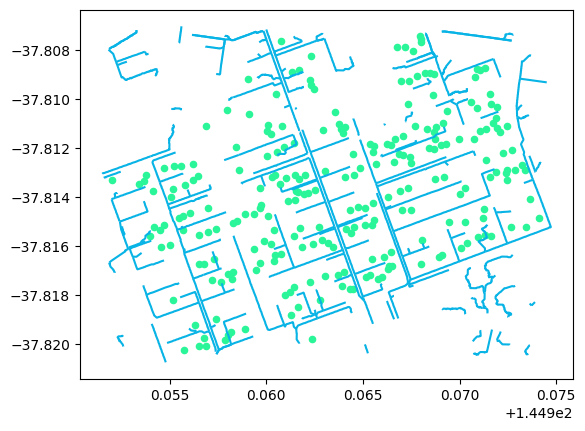

In [100]:
# Map water_gdf and Lane_gdf to look for overlap
# Plot the lane_gdf and water_gdf on the same axis using matpotlib.pyplot
f, ax = plt.subplots()
# Plot lane_gdf with o marker in green colour
lane_gdf.plot(ax=ax, marker='o', color='#2af598', markersize=20)
# Plot the water_gdf in blue coour on same graph as lane_gdf
water_gdf.plot(ax=ax, color='#08b3e5')
# Show the plot
plt.show()

The map shows where surface water flows in blue and the location of laneways in green. There are locations where these points overlap. These are the points of interest, that should be considered for the Green Your Laneway project next.

##### **Interactive map showing with laneway names and stream order of water runoff on roads**

In [104]:
# Create map object of water_gdf dataset, call explore method
m = water_gdf.explore(
    column="stream_flow_level",  # make choropleth based on "stream flow level" column
    cmap = "winter_r",  # set colormap to reverse winter,
    legend=True,  # show legend
    tooltip=False,  # hide tooltip
    popup=["stream_flow_level"],  # show popup (on-click) of stream flow value
    legend_kwds=dict(colorbar=False),  # do not use colorbar
    name="Water flow on land",  # name of the layer in the map
)
# Call explore method on lane_gdf
lane_gdf.explore(
    m=m,  # pass the map object that exists to the lane_gdf explore object
    # this makes both datasets map together
    color="blue",  # use blue color on all points
    marker_kwds=dict(radius=3, fill=True),  # set the marker for lane names
    tooltip="mapbase_1",  # show names of the lane when the marker is hovered
    tooltip_kwds=dict(labels=False),  # do not show column label in hover
    name="Laneway names",  # name of the layer in the map
)

# Use folium to add alternative tiles
folium.TileLayer().add_to(m)  
# Use folium to add layer control
folium.LayerControl().add_to(m)  

# Show map
m 

The interactive graph allows the use to select a lane name and check the stream order of water that runs along roadways. Higher stream order values indicates tribituary flow from other roadways. Tributuary lanes that are causing nearby roads to have higher stream order values should be considered first as the water runoff from these lanes causes greater water surface runoff on connecting roadways. Reducing surface water flow in tribituary lanes will reduce water flow to larger roads, therefre reducing total flow of water on the surface.

##### **Names of laneways with surface water flow**

In [147]:
import warnings
warnings.filterwarnings("ignore")
# Find rows from where the laneways and surface water flow intersect
# Use sjoin_nearest method to do an inner join on lane_gdf and water_gdf
# Set the max_distance to allow for small discrepencies in tagging of lane names
joined_gdf = lane_gdf.sjoin_nearest(water_gdf, max_distance=0.0003)
# Select specific data rows
joined_gdf = joined_gdf[["stream_flow_level","geometry","mapbase_1"]]
# Sort values in descending order f highest strea flow level first
joined_gdf = joined_gdf.sort_values(by='stream_flow_level',ascending=False)
# Print length of dataframe to find number of laneways impacted by surface water flow
print(len(joined_gdf))
# Print the head of the joined data
print(joined_gdf.head(5))
# Graph the locations of the laneways where there is water flow on land
joined_gdf.explore()


82
    stream_flow_level                     geometry    mapbase_1
48                  4  POINT (144.96447 -37.81777)       Cl0496
53                  3  POINT (144.95548 -37.81488)  Brown Alley
185                 2  POINT (144.96555 -37.81218)  Globe Alley
208                 2  POINT (144.96028 -37.81317)  Crown Place
97                  2  POINT (144.96862 -37.80981)   Jones Lane


By finding the intersection of geographical co-ordinates of laneway names and polygon of locations of surface water flow on land, a dataframe of laneways that have surface water flow issues in rain events can be made. This is sorted from the highest to lowest stream flow to assist with decision making in the order of laneway planting sequence. Laneways with highest stream flow should be considered for planting before laneways with lower stream flow. Certainly, the 82 laneways with reported stream flow should be prioritised for the Green Your Laneway program prior to laneways where surface water flow is not an issue.

##### References

<fn id="fn-1">[1] Melbourne City Council (2023) Greening laneways - City of Melbourne. City of Melbourne Council, Australia. Available at: https://www.melbourne.vic.gov.au/community/greening-the-city/green-infrastructure/Pages/greening-laneways.aspx</fn>

<fn id="fn-2">[2] Trees for Cities (2023) Trees in our Cities: 10 Reasons we need to plant more. Trees for Cities Organisation, England. Available at: https://www.treesforcities.org/stories/trees-in-our-cities-10-reasons-we-need-to-plant-more</fn>

<fn id="fn-3">[3] Institute of Chartered Foresters (2017) Trees can reduce floods. Institute of Chartered Foresters Organisation, England. Available at: https://www.charteredforesters.org/trees-can-reduce-floods</fn>

<fn id="fn-4">[4] Vistoria State of Emergency Service (2021) Melbourne CBD
Local Flood Guide - Flash Flood information for Melbourne CBD. City of Melbourne Council, Australia. Available at: https://www.ses.vic.gov.au/documents/8655930/9320133/Melbourne+CBD+-+LFG+-+Draft+1.3.pdf/10235674-fc8e-8515-f167-a1cb7f7a4531?version=1.0&t=1634863369470h</fn>

